# Postprocess locations from DLC and a video

In [64]:
import h5py
import os
import matplotlib.pyplot as plt

from DLC_for_WBFM.utils.postprocessing.postprocessing_utils import *
import cv2
import torch
import tifffile

from ipywidgets import interact, interactive, fixed, interact_manual
from dNMF.Demix.dNMF import dNMF
import time
import scipy.io as scio
from sklearn.decomposition import FastICA

## BEFORE ANYTHING: move the gcamp video to the project folder!

## First, read the locations from DLC

In [2]:
which_neuron = 0; # For this example, should be AVA

In [4]:
# Get the video folder, then the annotation
# folder_name = '/users/charles.fieseler/shared_projects/wbfm/dat/immobilized_wbfm_hardware/'
project_folder = '/users/charles.fieseler/DLC_for_WBFM/DLC_Projects/Chip_with_WBFM_hardware_z8-Charlie-2020-10-12/'

annotation_fname = 'videos/27082020_trial2_HEAD_500frames_mcherry_slice8DLC_resnet50_Chip_with_WBFM_hardware_z8Oct12shuffle1_5000.h5'
annotation_fname = os.path.join(project_folder, annotation_fname)

# Will get traces from two videos:
video_fname_mcherry = 'videos/27082020_trial2_HEAD_500frames_mcherry_slice8.avi'
video_fname_mcherry = os.path.join(project_folder, video_fname_mcherry)
video_fname_gcamp = 'videos/27082020_trial2_HEAD_500frames_gcamp_slice8.avi'
video_fname_gcamp = os.path.join(project_folder, video_fname_gcamp)

In [5]:
# Get the positions from the annotation: ONE neuron
this_xy, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=which_neuron, num_frames=500)

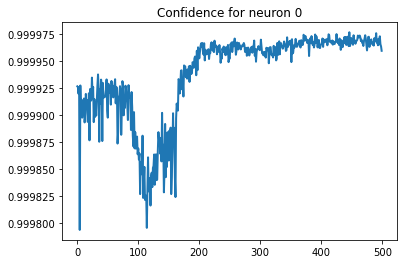

In [6]:
plt.plot(this_prob, lw=2)
# plt.ylim([0,1])
plt.title(f'Confidence for neuron {which_neuron}');

## Second, get a moving crop centering this neuron

In [12]:
# Use video from above

num_frames = 500
sz=(15,15)

cropped_dat_mcherry = get_crop_from_avi(video_fname_mcherry, this_xy, num_frames, sz=sz)
cropped_dat_gcamp = get_crop_from_avi(video_fname_gcamp, this_xy, num_frames, sz=sz)

In [18]:
def f(i): 
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(cropped_dat_mcherry[:,:,0,i]);
    plt.title('mcherry')
    plt.colorbar()
    plt.clim(0, 200)
    
    plt.subplot(122)
    plt.imshow(cropped_dat_gcamp[:,:,0,i]);
    plt.title('gcamp')
    plt.colorbar()
    plt.clim(0, 200)
interact(f, i=(0,num_frames-1));

interactive(children=(IntSlider(value=249, description='i', max=499), Output()), _dom_classes=('widget-interac…

## Aside: Simple ways to get traces

Find the direct maximum and the mean of top 10%

In [19]:
max_coords, max_values = local_maxima_2D(cropped_dat_mcherry[:,:,0,:])

In [21]:
def f(i):
    plt.figure(figsize=[15,5])
    
    plt.subplot(121)
    plt.imshow(cropped_dat_mcherry[:,:,0,i], vmin=50, vmax=np.amax(max_values));
    plt.title(f'mcherry Max = {max_values[i]}')
    
    plt.subplot(122)
    plt.plot(max_values)
    plt.scatter(i, max_values[i], c='r', linewidths=5)
interact(f, i=(0,num_frames-1));

interactive(children=(IntSlider(value=249, description='i', max=499), Output()), _dom_classes=('widget-interac…

In [23]:
mean_percentile_values = mean_of_top_percentile(cropped_dat_mcherry[:,:,0,:], percentile=95)

In [24]:
def f(i):
    plt.figure(figsize=[15,5])
    
    plt.subplot(121)
    plt.imshow(cropped_dat_mcherry[:,:,0,i], vmin=50, vmax=np.amax(max_values));
    plt.colorbar()
    plt.title(f'mcherry Mean of top 10% = {mean_percentile_values[i]}')
    
    plt.subplot(122)
    plt.plot(mean_percentile_values, label='Mean of top 10%')
    plt.plot(max_values, label='Max')
    plt.scatter(i, mean_percentile_values[i], c='r', linewidths=5)
    plt.legend()
interact(f, i=(0,num_frames-1));

interactive(children=(IntSlider(value=249, description='i', max=499), Output()), _dom_classes=('widget-interac…

## Run dNMF

In [25]:
# %% Choosing the parameters
params = {'n_trials':5, 'noise_level':1e-2, 'sigma_inv':.2, 
          'radius':10, 'step_S':.1, 'gamma':0, 'stride_factor':2, 'density':.1, 'varfact':5,
          'traj_means':[.0,.0,.0], 'traj_variances':[2e-4,2e-4,1e-5], 'sz':[20,20,1], 
          'K':20, 'T':100, 'roi_window':[4,4,0]}

In [30]:
# Build position and convert to pytorch
positions =[list(sz + (0,)),[0, 0, 0]] # Add a dummy position
positions = np.expand_dims(positions,2)/2.0 # Return the center of the crop
positions =  torch.tensor(positions).float()

# Also convert video to pytorch
dat_mcherry = torch.tensor(cropped_dat_mcherry).float()
dat_gcamp = torch.tensor(cropped_dat_gcamp).float()

params = {'positions':positions[:,:,0][:,:,np.newaxis],\
    'radius':params['radius'],'step_S':params['step_S'],'gamma':params['gamma'],\
    'use_gpu':False,'initial_p':positions[:,:,0],'sigma_inv':params['sigma_inv'],\
    'method':'1->t', 'verbose':False}

In [31]:
start = time.time()
# Initialize using the following from the ground truth:
#  Initial positions
#  Radius
#  
dnmf_mcherry = dNMF(dat_mcherry,params=params)
dnmf_gcamp = dNMF(dat_gcamp,params=params)

dnmf_mcherry.optimize(lr=1e-4,n_iter=20,n_iter_c=2)
print("Finished mcherry, now doing gcamp...")
dnmf_gcamp.optimize(lr=1e-4,n_iter=20,n_iter_c=2)
end = time.time()
print('dNMF finished in ' + str(end-start) + ' seconds')

dNMF finished in 148.16794061660767 seconds


## Plot the dNMF traces

In [51]:
# Get comparison wb traces 
mat_fname = 'videos/wbstruct_trial2_dual1_HEAD_500frames_AVAL_R_AIBR_Marked.mat'
mat_fname = os.path.join(project_folder, mat_fname)

wb_struct = scio.loadmat(mat_fname)

In [54]:
# AVA_ind = filter(lambda x: 'AVAL' in x, wb_dat['ID'])
# print(AVA_ind)
AVA_ind = 26; # TODO: by hand
t_ind = range(500)
wb_dat = wb_struct['deltaFOverF'][t_ind, AVA_ind]

Text(0.5, 1.0, 'trace from wb')

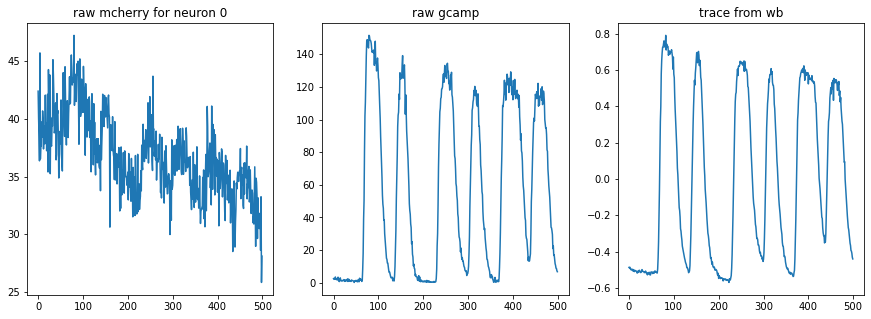

In [105]:

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(dnmf_mcherry.C[0,:]) # This index is which neuron within the crop
plt.title(f'raw mcherry for neuron {which_neuron}')

plt.subplot(132)
plt.plot(dnmf_gcamp.C[0,:]) # This index is which neuron within the crop
plt.title('raw gcamp')

plt.subplot(133)
plt.plot(wb_dat)
plt.title('trace from wb')


## Workflows to denoise gcamp using mcherry

### First, ICA

In [103]:
# Data shaping
X = np.vstack((dnmf_mcherry.C[0,:], dnmf_gcamp.C[0,:])).transpose()
transformer = FastICA(n_components=2, random_state=0)
X_transformed = transformer.fit_transform(X)

Text(0.5, 1.0, 'trace from wb')

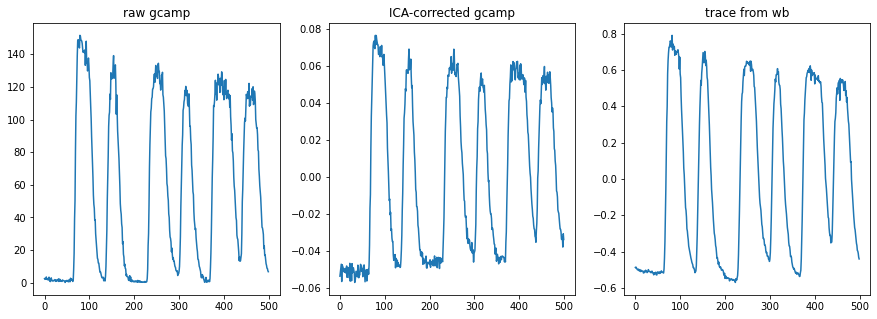

In [104]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(dnmf_gcamp.C[0,:]) # This index is which neuron within the crop
plt.title('raw gcamp')

plt.subplot(132)
plt.plot(-X_transformed[:,0]) # This index is which neuron within the crop
plt.title('ICA-corrected gcamp')

plt.subplot(133)
plt.plot(wb_dat)
plt.title('trace from wb')

### Second, ratiometric

Text(0.5, 1.0, 'trace from wb')

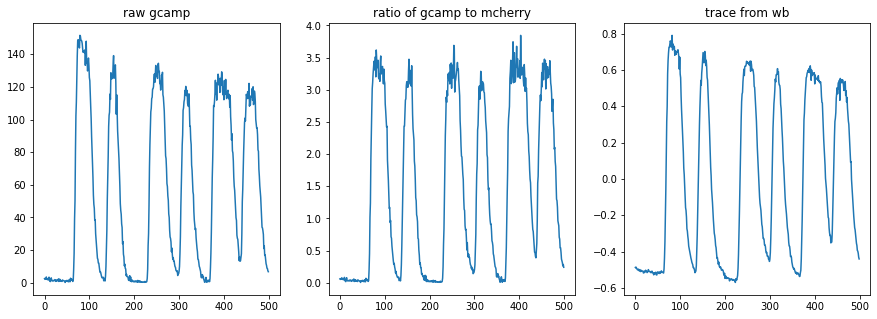

In [97]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(dnmf_gcamp.C[0,:]) # This index is which neuron within the crop
plt.title('raw gcamp')

plt.subplot(132)
plt.plot(dnmf_gcamp.C[0,:] / dnmf_mcherry.C[0,:]) # This index is which neuron within the crop
plt.title('ratio of gcamp to mcherry')

plt.subplot(133)
plt.plot(wb_dat)
plt.title('trace from wb')

## Not working: visualize neuron footprints

In [57]:
neuron_names = [str(i) for i in range(positions.shape[0])]
# dnmf.visualize_traces('result', [dnmf.C], save=False)
# dnmf.visualize_traces('result',np.expand_dims(dnmf.C, axis=-1), neuron_names, save=False)
# dnmf_mcherry.visualize_neurons(f'Results2d_neuron{which_neuron}', [['0','1']], neuron_names, dat, window=np.array([10,10]))

In [70]:
X_transformed.shape

(2, 2)

In [71]:
X_transformed


array([[-0.66296526,  0.29762043],
       [ 1.05797724,  0.2169224 ]])